Running on Kaggle's GPU T4 x 2

In [102]:
# Imports
from wordcloud import STOPWORDS

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import string

# Configurations
pd.set_option('display.max_colwidth', 140)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants
SEED = 42

In [103]:
# Loading Data
train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [104]:
# Shapes
print(f'Train Shape: {train.shape}\nTest Shape: {test.shape}')

Train Shape: (7613, 5)
Test Shape: (3263, 4)


In [105]:
# Sample data to see what is there to work with
train.sample(10, random_state = SEED)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0
5559,7934,rainstorm,NaN,@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time,0
1765,2538,collision,NaN,my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS,1
1817,2611,crashed,NaN,@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS,1
6810,9756,tragedy,"Los Angeles, CA",Can't find my ariana grande shirt this is a fucking tragedy,0
4398,6254,hijacking,"Athens,Greece",The Murderous Story Of AmericaÛªs First Hijacking http://t.co/EYUGk6byxr,1


## EDA

### 1. Missing Values

In [106]:
# Keyword
kw_missing_ratio_train = train['keyword'].isnull().sum() / train.shape[0] * 100
kw_missing_ratio_test = test['keyword'].isnull().sum() / test.shape[0] * 100

# Location
loc_missing_ratio_train = train['location'].isnull().sum() / train.shape[0] * 100
loc_missing_ratio_test = test['location'].isnull().sum() / test.shape[0] * 100

# Show results insights:
print(f'Train data has {kw_missing_ratio_train:.2f}% of missing values concerning the "keyword" feature.')
print(f'Train data has {loc_missing_ratio_train:.2f}% of missing values concerning the "location" feature.\n')
print(f'Test data has {kw_missing_ratio_test:.2f}% of missing values concerning the "keyword" feature.')
print(f'Test data has {loc_missing_ratio_test:.2f}% of missing values concerning the "location" feature.')

Train data has 0.80% of missing values concerning the "keyword" feature.
Train data has 33.27% of missing values concerning the "location" feature.

Test data has 0.80% of missing values concerning the "keyword" feature.
Test data has 33.86% of missing values concerning the "location" feature.


Missing values ratios are very closed when compared between datasets.

#### 1.1. Filling in missing values for `keyword`and `location`

In [107]:
cols_w_missing_values = ['keyword', 'location']
dataframes = {'Train': train, 'Test': test}

for name, df in dataframes.items():
    for col in cols_w_missing_values:
        df[col] = df[col].fillna(f'no{col}')
        
        # Check imputations:
        missing_pct = df[col].isnull().sum() / train.shape[0] * 100
        print(f'{name} data has {missing_pct:.2f}% of missing values concerning the "{col}" feature.')
    print()

Train data has 0.00% of missing values concerning the "keyword" feature.
Train data has 0.00% of missing values concerning the "location" feature.

Test data has 0.00% of missing values concerning the "keyword" feature.
Test data has 0.00% of missing values concerning the "location" feature.



### 1.2. Keyword values between train and test. Is there something we won't be seeing at training?

In [108]:
train_kw_unique_values = train['keyword'].unique()
test_kw_unique_values = test['keyword'].unique()

print(f'Train data has {len(train_kw_unique_values)} distinct values. Test data contains {len(test_kw_unique_values)} distinct values.') # Same counts but are them the same?

if np.array_equal(train_kw_unique_values, test_kw_unique_values):
    print('Train and Test share the same unique values of "keyword".')
else:
    print('Train and Test DO NOT share the same unique values of "keyword".')

Train data has 222 distinct values. Test data contains 222 distinct values.
Train and Test share the same unique values of "keyword".


### 1.3. How Keywords Are Related To Target?

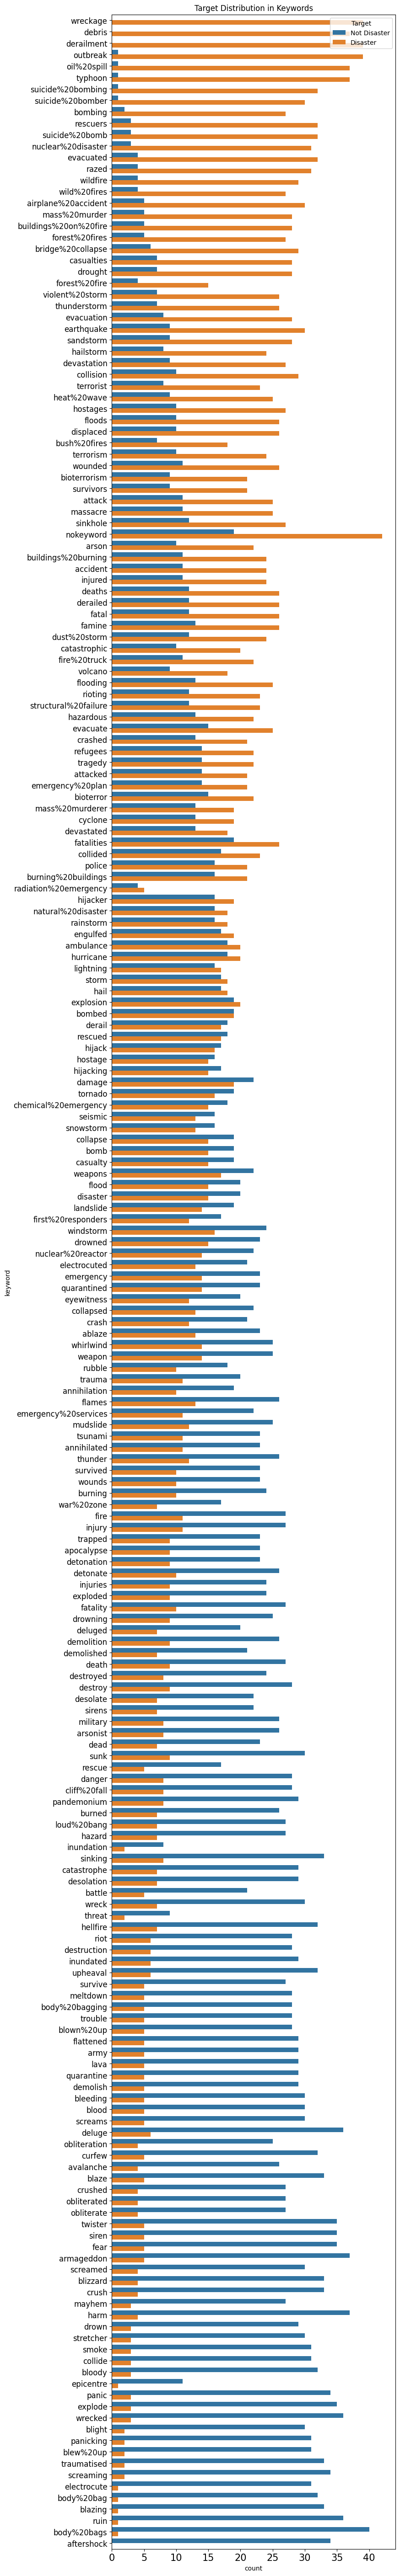

In [109]:
train['target_mean'] = train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sorted_train = train.sort_values(by='target_mean', ascending=False)

sns.countplot(y=sorted_train['keyword'],
              hue=sorted_train['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(
    title='Target',
    labels=['Not Disaster', 'Disaster'],
    loc='upper right'
)
plt.title('Target Distribution in Keywords')

plt.show()

train.drop(columns=['target_mean'], inplace=True)

## 2.Feature Engeneering

In [110]:
for _, df in dataframes.items():
    # Words in tweet:
    df['words_count'] = df['text'].apply(lambda x: len(str(x).split()))

    # Unique words in tweet:
    df['unique_words_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
    
    # STOPWORDS count in tweet:
    df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

    # URLs count:
    df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

    # Mean word length:
    df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

    # Characters count:
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))

    # Punctuation count:
    df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    # Hashtag count
    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

    # Mention count
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

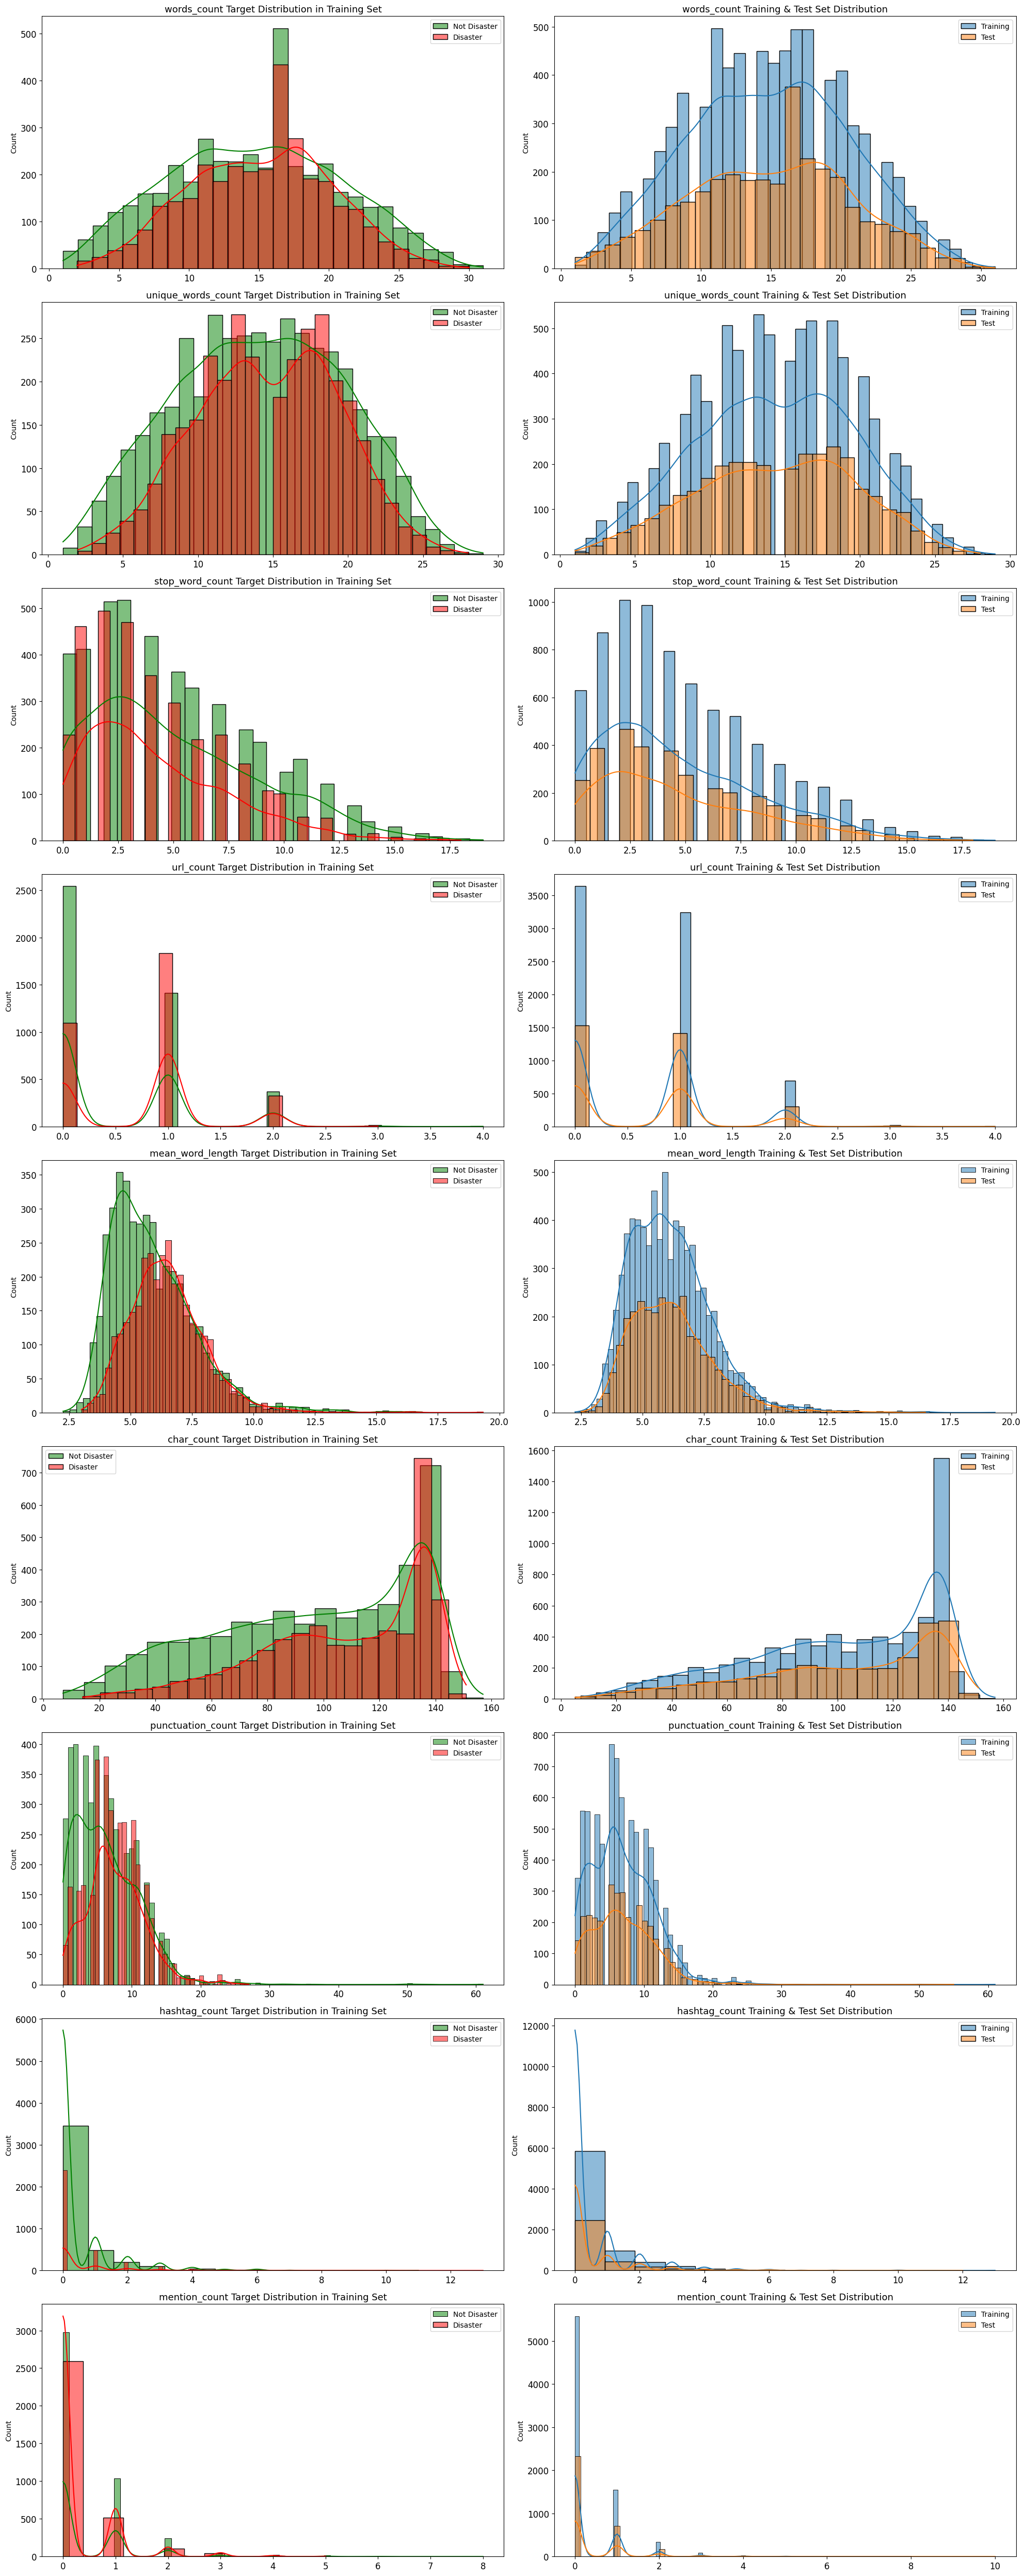

In [111]:
train.dropna(inplace=True)
test.dropna(inplace=True)

new_features = ['words_count', 'unique_words_count', 'stop_word_count', 'url_count', 
                'mean_word_length', 'char_count', 'punctuation_count', 
                'hashtag_count', 'mention_count']

disaster_tweets = train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(new_features), figsize=(20, 50), dpi=100)

for i, feature in enumerate(new_features):
    sns.histplot(train.loc[~disaster_tweets][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(train.loc[disaster_tweets][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)

    sns.histplot(train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(test[feature], label='Test', ax=axes[i][1], kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.tight_layout()
plt.show()

https://colab.research.google.com/drive/1ZY9IQZ_ZeqjbBEDKWHgcldaY_zRZrh2R?usp=sharing#scrollTo=UFp6G9LgfL8y